In [98]:
import gym
import numpy as np
env = gym.make('Taxi-v3', render_mode="rgb_array")
env.reset()

(246, {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)})

In [99]:
# 6 primitive actions ["south,north,east,west,pick,drop"]
action = np.random.randint(0, 6)
next_state, reward, done, truncated, info = env.step(action)

In [100]:
env.spec

EnvSpec(id='Taxi-v3', entry_point='gym.envs.toy_text.taxi:TaxiEnv', reward_threshold=8, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='Taxi', version=3)

In [101]:
"Id: [0:Red,1:Green,2:Yellow,3:Blue,4:Taxi]"
taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(114)

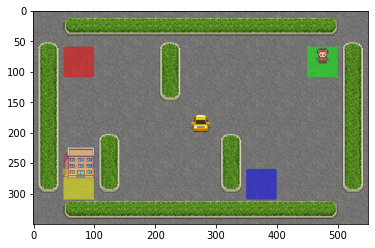

In [102]:
import matplotlib.pyplot as plt

plt.imshow(env.render())
output_filename = 'output_image.png'
plt.savefig(output_filename, format='png')

# Epsilon Greedy Exploration

In [103]:
def epsilon_greedy(q_values, state, epsilon):
    if q_values[state].any() and np.random.random() > epsilon:
        return np.argmax(q_values[state])
    choice = np.random.randint(0, q_values.shape[-1]-1)
    return choice

In [104]:
def xy_to_state(x, y):
    return 5*x+y

# Defined Option

In [105]:
# 4 different q tables to maintain for each goal square
# goal  =[red,green,yellow,blue]
def Option(Q, state, square_colour, goal, eps=0.1):
    optdone = False
    taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
        state)
    if taxi_row == goal[square_colour][0] and taxi_col == goal[square_colour][1]:
        optdone = True
        if passenger_location_id == square_colour:
            optact = 4
        elif drop_location_id == square_colour:
            optact = 5
        else:
            if square_colour == 0:
                optact = 0
            elif square_colour == 1:
                optact = 0
            elif square_colour == 2:
                optact = 1
            else:
                optact = 1
    else:
        optact = epsilon_greedy(Q[square_colour], xy_to_state(
            taxi_row, taxi_col), epsilon=eps)
    return [optact, optdone]

In [106]:
def get_grid_no_drop(pas, drop, nDrops=4):
    return nDrops*pas+drop

# Training Loop

In [107]:
from collections import deque
# yellow = [4,0]
# blue = [4,3]
# red  = [0,0]
# green = [0,4]
# goal  =[red,green,yellow,blue]
goals = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}
gamma = 0.9
alpha = 0.1
number_options = 4
nPas = 5  # number of passengger locations
nDrops = 4  # number of drop locations
# 4 each different locations , i am learning best option for that
# q table for the 25 cells and 4 actions excluding the pick and drop, for all the options
Qopt = {i: np.zeros((25, 4))
        for i in range(number_options)}

Q_smdp = np.zeros((nPas*nDrops, number_options))
state_counts = np.zeros((25, nPas*nDrops))
epsilon = [0.1 for i in range(number_options)]
epsilon_min = 0.01
decay_factor = 0.99
episodes = 2000
count = 0
rewards_smdp = []
goal = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}
eps_q = 0.2
score_history = deque(maxlen=100)
for i in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
            state)
        subState = get_grid_no_drop(passenger_location_id, drop_location_id)
        action = epsilon_greedy(Q_smdp, subState, epsilon=eps_q)
        eps_q = max(epsilon_min, eps_q*decay_factor)
        reward_bar = 0
        optdone = False
        k = 0
        prev = state
        while not optdone and not done:
            optact, optdone = Option(
                Qopt, state, action, goal, epsilon[action])

            taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                state)
            dropgridno_old = get_grid_no_drop(
                passenger_location_id, drop_location_id)
            next_state, reward, done, _, _ = env.step(optact)
            taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
                next_state)
            total_reward += reward
            reward_bar = gamma*reward_bar + reward
            k += 1
            epsilon[action] = max(
                epsilon_min, epsilon[action]*decay_factor)
            reward_surr = reward
            if optact < 4:

                Qopt[action][xy_to_state(taxi_row, taxi_col), optact] = Qopt[action][xy_to_state(taxi_row, taxi_col), optact]+alpha*(
                    reward_surr+gamma*np.max(Qopt[action][xy_to_state(taxi_row_new, taxi_col_new), :])-Qopt[action][xy_to_state(taxi_row, taxi_col), optact])
            state = next_state

            state_counts[5*taxi_row_new+taxi_col_new, dropgridno_old] += 1
        taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
            state)
        dropgridno_new = get_grid_no_drop(
            passenger_location_id, drop_location_id)
        taxi_row_prev, taxi_col_prev, passenger_location_id, drop_location_id = env.decode(
            state)
        dropgridno_old = get_grid_no_drop(
            passenger_location_id, drop_location_id)
        taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
            state)
        # this is where the smdp update is done
        # state_counts[5*taxi_row_prev+taxi_col_prev, dropgridno_old] += 1
        Q_smdp[dropgridno_old, action] += alpha*(reward_bar+(gamma**k)*np.max(
            Q_smdp[dropgridno_new, :])-Q_smdp[dropgridno_old, action])
        taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
            state)

        if passenger_location_id == drop_location_id:
            count += 1
    rewards_smdp.append(total_reward)
    score_history.append(total_reward)
    if (i+1) % 100 == 0:
        print(f"Episode {i+1} : Average Reward = {np.mean(score_history)}")
    if np.mean(score_history) >= 8:
        print(
            f"Environment solved in {i+1} epsiodes Average Reward:{np.mean(score_history)}")
        break

Episode 100 : Average Reward = -106.36
Episode 200 : Average Reward = -14.81
Episode 300 : Average Reward = -2.85
Episode 400 : Average Reward = 0.28
Episode 500 : Average Reward = 4.16
Episode 600 : Average Reward = 5.64
Episode 700 : Average Reward = 5.84
Episode 800 : Average Reward = 5.95
Episode 900 : Average Reward = 6.83
Episode 1000 : Average Reward = 6.86
Episode 1100 : Average Reward = 6.58
Episode 1200 : Average Reward = 6.95
Episode 1300 : Average Reward = 7.53
Episode 1400 : Average Reward = 7.21
Episode 1500 : Average Reward = 7.46
Episode 1600 : Average Reward = 7.29
Episode 1700 : Average Reward = 7.28
Episode 1800 : Average Reward = 7.4
Episode 1900 : Average Reward = 7.67
Environment solved in 1924 epsiodes Average Reward:8.0


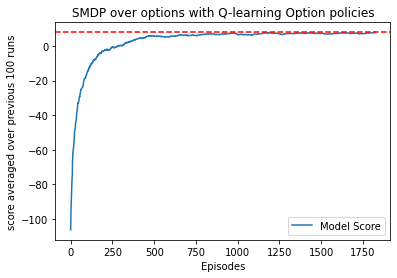

In [108]:
import matplotlib.pyplot as plt
window = 100
avg_rews_smdp = [np.average(rewards_smdp[i:i+window])
                 for i in range(len(rewards_smdp)-window)]
plt.plot(avg_rews_smdp, label='Model Score')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP over options with Q-learning Option policies')
plt.legend()
plt.axhline(y=8, color='red', linestyle='--')

# Testing the Learnt Policy

In [109]:
env = gym.make("Taxi-v3", render_mode="human")
state, _ = env.reset()
done = False
q_values_SMDP = Q_smdp
net_reward = 0
x, y, pas, drop = env.decode(state)
subState = nDrops*pas+drop
print(f"Runnning the training for substate={subState}")
while not done:
    x, y, pas, drop = env.decode(state)
    subState = nDrops*pas+drop
    option = epsilon_greedy(q_values_SMDP, subState, epsilon=0)
    optdone = False
    move = 0
    prev = state
    while (optdone == False) and not done:
        x, y, pas, drop = env.decode(state)
        optdone = False
        while not optdone and not done:
            optact, optdone = Option(Qopt, state, option, goal, 0)
            next_state, reward, done, _, _ = env.step(optact)
            net_reward += reward
            env.render()
            state = next_state
print(f"Net reward for this substate = {net_reward}")

Runnning the training for substate=8
Net reward for this substate = 12


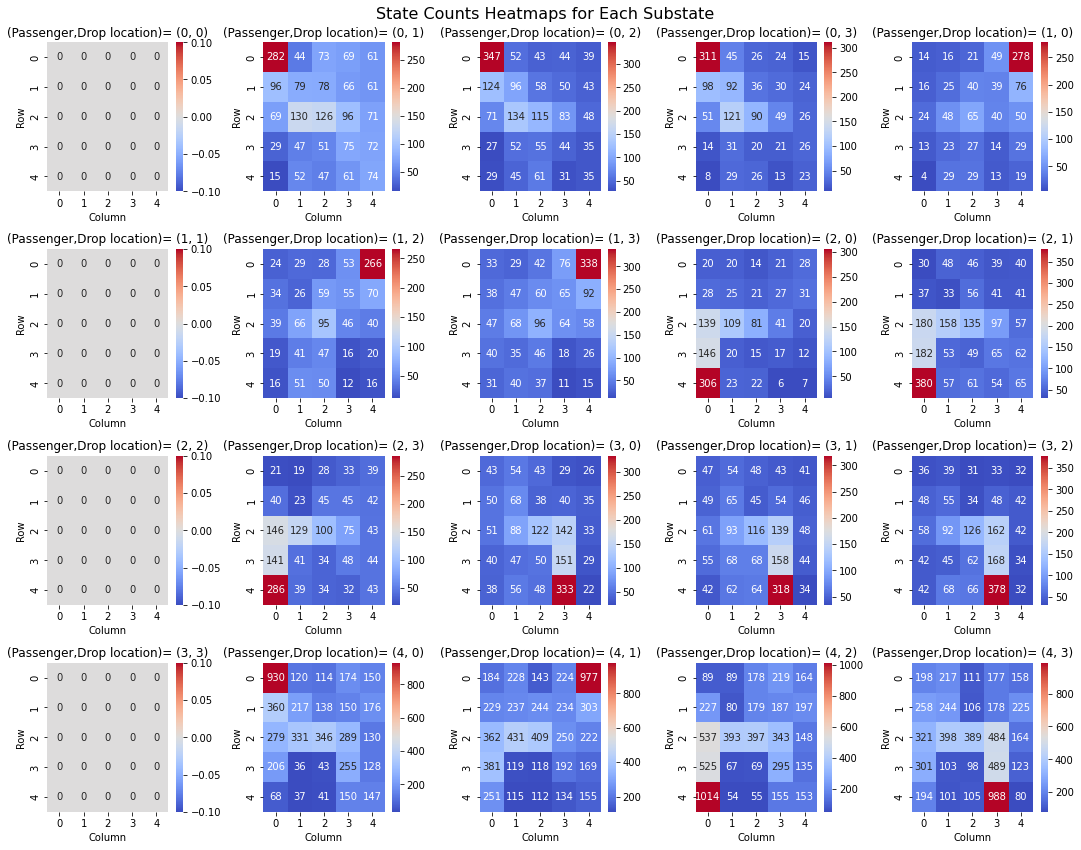

In [110]:
import seaborn as sns
state_array = np.array(state_counts, dtype="int")
num_substates = 20
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for substate in range(num_substates):
    substate_counts_1d = state_array[:, substate]
    substate_counts_2d = substate_counts_1d.reshape((5, 5))

    ax = axes[substate // 5, substate % 5]

    sns.heatmap(substate_counts_2d, annot=True,
                cmap='coolwarm', fmt='d', ax=ax)

    ax.set_title(
        f'(Passenger,Drop location)= {substate//nDrops,substate%nDrops}')

    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

fig.suptitle('State Counts Heatmaps for Each Substate', fontsize=16)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Policy learnt by SMDP')

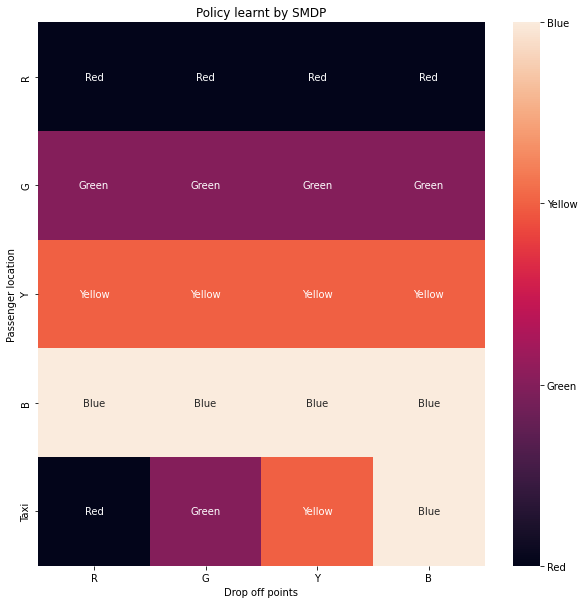

In [111]:
import seaborn as sns

Qmax_SMDP = np.argmax(q_values_SMDP, axis=1).reshape(5, 4)
labels = {0: 'Red', 1: 'Green', 2: 'Yellow', 3: 'Blue'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(Qmax_SMDP, ax=axis, xticklabels=["R", "G", "Y", "B"], yticklabels=[
                 'R', 'G', 'Y', 'B', 'Taxi'], annot=annot_text, fmt='')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['Red', 'Green', 'Yellow', 'Blue'])
axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy learnt by SMDP')

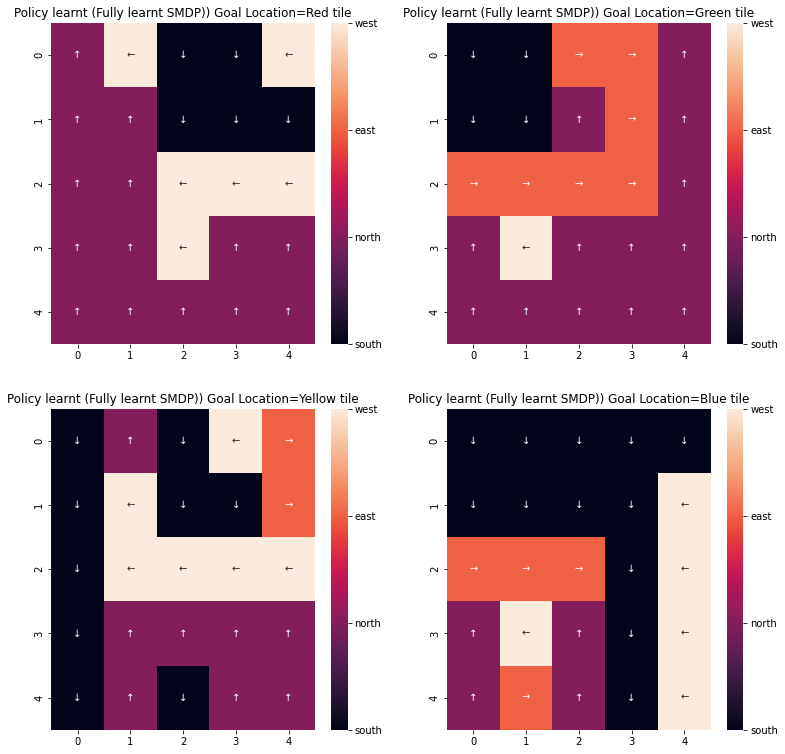

In [112]:
figure, axis = plt.subplots(2, 2, figsize=(13, 13))
goal_labels = ['Red', 'Green', 'Yellow', 'Blue']
for i in range(2):
    for j in range(2):
        arrows = {0: '↓', 1: '↑', 2: '→', 3: '←'}
        annot_text = np.vectorize(arrows.get)(
            np.argmax(Qopt[2*i+j], axis=1).reshape(5, 5))
        ax = sns.heatmap(np.argmax(
            Qopt[2*i+j], axis=1).reshape(5, 5), ax=axis[i, j], annot=annot_text, fmt='')
        axis[i, j].set_title(
            "Policy learnt (Fully learnt SMDP)) Goal Location={} tile".format(goal_labels[i*2+j]))
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i for i in range(4)])
        c_bar.set_ticklabels(['south', 'north', 'east', 'west'])
plt.show()

# Alternative Option test

In [116]:
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3")
state, _ = env.reset()

number_drops = 0
gamma = 0.9
alpha = 0.1
number_options = 4
nPas = 5  # number of passengger locations
nDrops = 4  # number of drop locations

Q_smdp = np.zeros((25, nPas*nDrops, number_options))

state_counts = np.zeros((25, nPas*nDrops))
epsilon_min = 0.01
decay_factor = 0.9
episodes = 3500
count = 0
rewards_smdp = []
# goal = {'top_x': 0, 'left_y': 0, 'bottom_x': 4, 'right_y': 4}
# action 0, 1 2 3  N S E W
eps_q = 0.1
score_history = deque(maxlen=100)
number_drops = 0
for i in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    truncated = False
    in_taxi = False
    action_counts = [0, 0, 0, 0]
    steps = 0
    while not done and not truncated:
        taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
            state)
        subState = get_grid_no_drop(passenger_location_id, drop_location_id)
        action = epsilon_greedy(
            Q_smdp[5*taxi_row+taxi_col], subState, epsilon=eps_q)
        eps_q = max(epsilon_min, eps_q*decay_factor)
        reward_bar = 0
        optdone = False
        k = 0
        prev = [taxi_row, taxi_col]
        state_counts[5*taxi_row+taxi_col, subState] += 1
        if not optdone and not done:
            optact = action
            for j in range(2):
                taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                    state)
                next_state, reward, done, truncated, _ = env.step(optact)
                steps += 1
                taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
                    next_state)
                state_counts[5*taxi_row_new+taxi_col_new, subState] += 1
                total_reward += reward
                reward_bar = gamma*reward_bar + reward
                k += 1
                reward_surr = reward

                taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                    next_state)
                locations = {0: [0, 0], 1: [0, 4], 2: [4, 0],
                             3: [4, 3], 4: [taxi_row, taxi_col]}
                loc = locations[passenger_location_id]
                if loc[0] == taxi_row and loc[1] == taxi_col and drop_location_id != passenger_location_id and not in_taxi:
                    optact = 4
                    in_taxi = True
                    optdone = True
                    next_state, reward, done, truncated, _ = env.step(optact)
                    break

                if goal[drop_location_id][0] == taxi_row and goal[drop_location_id][1] == taxi_col and passenger_location_id == 4 and in_taxi:
                    optact = 5
                    optdone = True
                    number_drops += 1
                    next_state, reward, done, truncated, _ = env.step(optact)
                    break

                state = next_state

            optdone = True

        dropgridno = get_grid_no_drop(
            passenger_location_id, drop_location_id)
        taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
            state)
        Q_smdp[prev[0]*5+prev[1], dropgridno, action] += alpha*(reward_bar+(gamma**k)*np.max(
            Q_smdp[taxi_row_new*5+taxi_col_new, dropgridno])-Q_smdp[prev[0]*5+prev[1], dropgridno, action])

    rewards_smdp.append(total_reward)
    score_history.append(total_reward)
    if (i+1) % 1 == 0:
        print(
            f"Episode {i+1} : Average Reward = {np.mean(score_history)}  Number_drops:{number_drops} steps:{steps}")

Episode 1 : Average Reward = -164.0  Number_drops:1 steps:164
Episode 2 : Average Reward = -154.5  Number_drops:2 steps:145
Episode 3 : Average Reward = -149.66666666666666  Number_drops:3 steps:140
Episode 4 : Average Reward = -160.5  Number_drops:4 steps:193
Episode 5 : Average Reward = -164.4  Number_drops:5 steps:180
Episode 6 : Average Reward = -156.33333333333334  Number_drops:6 steps:116
Episode 7 : Average Reward = -159.42857142857142  Number_drops:7 steps:178
Episode 8 : Average Reward = -157.75  Number_drops:8 steps:146
Episode 9 : Average Reward = -151.33333333333334  Number_drops:9 steps:100
Episode 10 : Average Reward = -156.1  Number_drops:9 steps:199
Episode 11 : Average Reward = -158.1818181818182  Number_drops:10 steps:179
Episode 12 : Average Reward = -152.91666666666666  Number_drops:11 steps:95
Episode 13 : Average Reward = -146.46153846153845  Number_drops:12 steps:69
Episode 14 : Average Reward = -144.71428571428572  Number_drops:13 steps:122
Episode 15 : Average 

# Testing Learned Policy


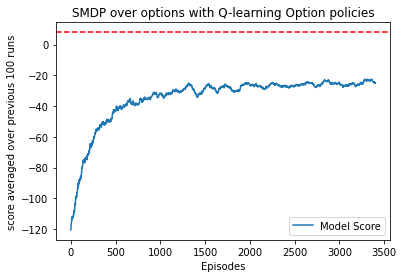

In [117]:
import matplotlib.pyplot as plt
window = 100
avg_rews_smdp = [np.average(rewards_smdp[i:i+window])
                 for i in range(len(rewards_smdp)-window)]
plt.plot(avg_rews_smdp, label='Model Score')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP over options with Q-learning Option policies')
plt.legend()
plt.axhline(y=8, color='red', linestyle='--')

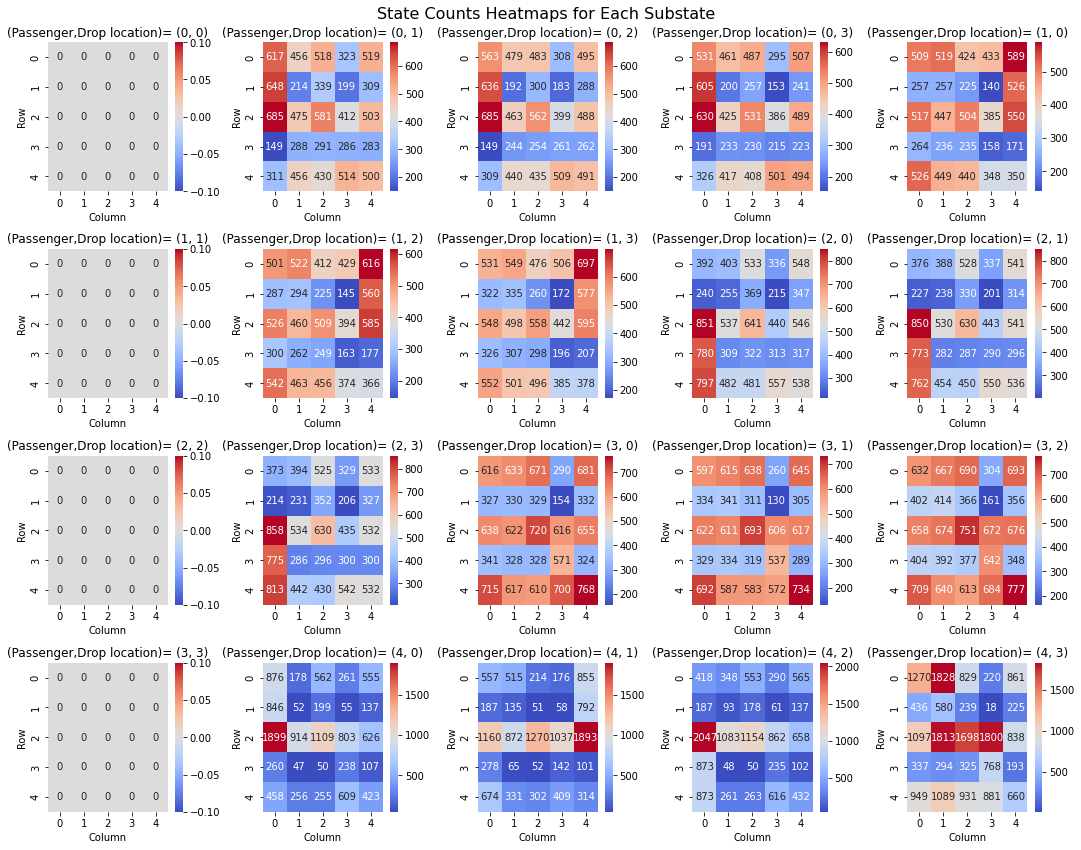

In [118]:
state_array = np.array(state_counts, dtype="int")
num_substates = 20
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for substate in range(num_substates):
    substate_counts_1d = state_array[:, substate]
    substate_counts_2d = substate_counts_1d.reshape((5, 5))

    ax = axes[substate // 5, substate % 5]

    sns.heatmap(substate_counts_2d, annot=True,
                cmap='coolwarm', fmt='d', ax=ax)

    ax.set_title(
        f'(Passenger,Drop location)= {substate//nDrops,substate%nDrops}')

    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

fig.suptitle('State Counts Heatmaps for Each Substate', fontsize=16)
plt.tight_layout()
plt.show()

In [120]:
env = gym.make("Taxi-v3", render_mode="human")
state, _ = env.reset()
done = False
in_taxi = False
q_values_SMDP = Q_smdp
total_reward = 0
x, y, pas, drop = env.decode(state)
print(f"Running for substate {nDrops*pas+drop}")
while not done:
    x, y, pas, drop = env.decode(state)
    subState = nDrops*pas+drop
    action = np.argmax(q_values_SMDP[5*x+y, subState])
    optdone = False
    move = 0
    prev = state
    while (optdone == False) and not done:
        x, y, pas, drop = env.decode(state)
        optdone = False
        if not optdone and not done:
            optact = action
            for j in range(2):
                taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                    state)
                next_state, reward, done, truncated, _ = env.step(optact)
                steps += 1
                taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
                    next_state)
                total_reward += reward
                reward_bar = gamma*reward_bar + reward
                reward_surr = reward
                locations = {0: [0, 0], 1: [0, 4], 2: [4, 0],
                             3: [4, 3], 4: [taxi_row, taxi_col]}
                loc = locations[passenger_location_id]
                taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                    next_state)
                if loc[0] == taxi_row and loc[1] == taxi_col and drop_location_id != passenger_location_id and not in_taxi:
                    optact = 4
                    in_taxi = True
                    optdone = True
                    next_state, reward, done, truncated, _ = env.step(optact)
                    total_reward += reward
                    break
                if goal[drop_location_id][0] == taxi_row and goal[drop_location_id][1] == taxi_col and passenger_location_id == 4:
                    optact = 5
                    optdone = True
                    number_drops += 1
                    next_state, reward, done, truncated, _ = env.step(optact)
                    total_reward += reward
                    break
                state = next_state
            optdone = True
print(f"Total Reward for this substate = {total_reward}")

Running for substate 1
Total Reward for this substate = 1


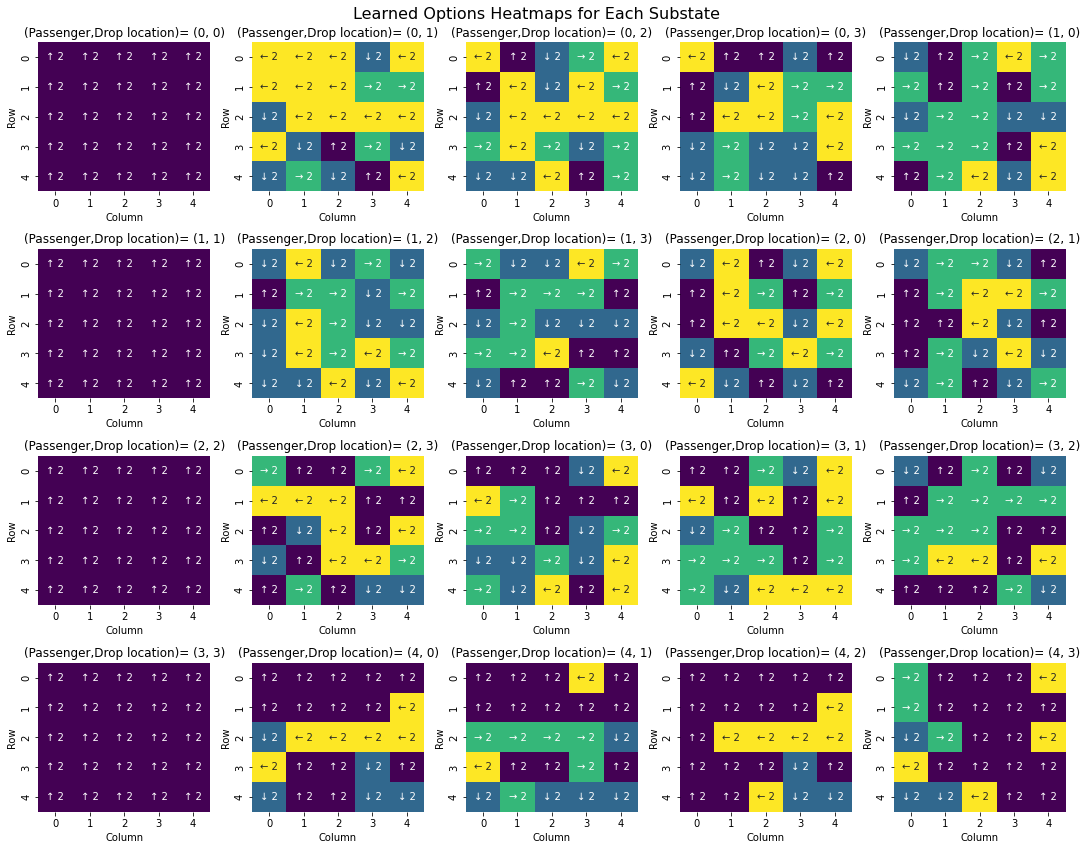

In [121]:
import seaborn as sns
substates = 20
option_names = {
    0: "↑ 2",
    1: "↓ 2",
    2: "→ 2",
    3: "← 2"
}
num_substates = 20

fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for substate in range(num_substates):
    learned_options = np.argmax(Q_smdp[:, substate], axis=1)
    learned_options_names = np.vectorize(option_names.get)(learned_options)
    learned_options_2d = learned_options.reshape((5, 5))
    annot_text = learned_options_names.reshape((5, 5))
    ax = axes[substate // 5, substate % 5]
    sns.heatmap(learned_options_2d, annot=annot_text,
                cmap='viridis', fmt='', ax=ax, cbar=False)
    ax.set_title(
        f'(Passenger,Drop location)= {substate//nDrops,substate%nDrops}')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

fig.suptitle('Learned Options Heatmaps for Each Substate', fontsize=16)
plt.tight_layout()
plt.show()

# Intra Option Alternative option

In [157]:
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3")
state, _ = env.reset()

number_drops = 0
gamma = 0.9
alpha = 0.4
number_options = 4
nPas = 5  # number of passengger locations
nDrops = 4  # number of drop locations

Q_intra = np.zeros((25, nPas*nDrops, number_options))

state_counts = np.zeros((25, nPas*nDrops))
epsilon_min = 0.01
decay_factor = 0.9
episodes = 10500
count = 0
rewards_smdp = []
# goal = {'top_x': 0, 'left_y': 0, 'bottom_x': 4, 'right_y': 4}
# action 0, 1 2 3  N S E W
eps_q = 0.1
score_history = deque(maxlen=100)
number_drops = 0
for i in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    truncated = False
    in_taxi = False
    action_counts = [0, 0, 0, 0]
    steps = 0
    while not done and not truncated:
        taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
            state)
        subState = get_grid_no_drop(passenger_location_id, drop_location_id)
        action = epsilon_greedy(
            Q_intra[5*taxi_row+taxi_col], subState, epsilon=eps_q)
        eps_q = max(epsilon_min, eps_q*decay_factor)
        reward_bar = 0
        optdone = False
        k = 0
        prev = [taxi_row, taxi_col]
        state_counts[5*taxi_row+taxi_col, subState] += 1
        if not optdone and not done:
            optact = action
            for j in range(2):
                taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                    state)
                next_state, reward, done, truncated, _ = env.step(optact)
                steps += 1
                taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
                    next_state)

                state_counts[5*taxi_row_new+taxi_col_new, subState] += 1
                total_reward += reward
                reward_bar = gamma*reward_bar + reward
                k += 1
                reward_surr = reward

                # taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                #     next_state)
                locations = {0: [0, 0], 1: [0, 4], 2: [4, 0],
                             3: [4, 3], 4: [taxi_row, taxi_col]}
                loc = locations[passenger_location_id]
                subState = get_grid_no_drop(
                    passenger_location_id, drop_location_id)
                if loc[0] == taxi_row and loc[1] == taxi_col and drop_location_id != passenger_location_id and not in_taxi:
                    optact = 4
                    in_taxi = True
                    optdone = True
                    next_state2, reward, done, truncated, _ = env.step(optact)
                    taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
                        next_state2)

                    taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                        next_state)
                    target = (1-optdone) * \
                        Q_intra[5*taxi_row_new+taxi_col_new, subState, action] + \
                        optdone * \
                        np.max(Q_intra[5*taxi_row_new+taxi_col_new, subState])
                    Q_intra[5*taxi_row+taxi_col, subState, action] = Q_intra[5*taxi_row+taxi_col, subState, action] + \
                        alpha*(reward+gamma*target -
                               Q_intra[5*taxi_row+taxi_col, subState, action])
                    break

                if goal[drop_location_id][0] == taxi_row and goal[drop_location_id][1] == taxi_col and passenger_location_id == 4 and in_taxi:
                    optact = 5
                    optdone = True
                    number_drops += 1
                    next_state2, reward, done, truncated, _ = env.step(optact)
                    taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
                        next_state2)
                    taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                        next_state)

                    target = (1-optdone) * \
                        Q_intra[5*taxi_row_new+taxi_col_new, subState, action] + \
                        optdone * \
                        np.max(Q_intra[5*taxi_row_new+taxi_col_new, subState])
                    Q_intra[5*taxi_row+taxi_col, subState, action] = Q_intra[5*taxi_row+taxi_col, subState, action] + \
                        alpha*(reward+gamma*target -
                               Q_intra[5*taxi_row+taxi_col, subState, action])
                    break

                target = (1-optdone) * \
                    Q_intra[5*taxi_row_new+taxi_col_new, subState, action] + \
                    optdone * \
                    np.max(Q_intra[5*taxi_row_new+taxi_col_new, subState])
                Q_intra[5*taxi_row+taxi_col, subState, action] = Q_intra[5*taxi_row+taxi_col, subState, action] + \
                    alpha*(reward+gamma*target -
                           Q_intra[5*taxi_row+taxi_col, subState, action])
                state = next_state
            optdone = True

        # taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
        #     state)
        # Q_smdp[prev[0]*5+prev[1], dropgridno, action] += alpha*(reward_bar+(gamma**k)*np.max(
        #     Q_smdp[taxi_row_new*5+taxi_col_new, dropgridno])-Q_smdp[prev[0]*5+prev[1], dropgridno, action])

    rewards_smdp.append(total_reward)
    score_history.append(total_reward)
    if (i+1) % 1 == 0:
        print(
            f"Episode {i+1} : Average Reward = {np.mean(score_history)}  Number_drops:{number_drops} steps:{steps}")

Episode 1 : Average Reward = -94.0  Number_drops:1 steps:94
Episode 2 : Average Reward = -122.5  Number_drops:2 steps:151
Episode 3 : Average Reward = -148.0  Number_drops:2 steps:199
Episode 4 : Average Reward = -160.75  Number_drops:2 steps:199
Episode 5 : Average Reward = -145.2  Number_drops:3 steps:83
Episode 6 : Average Reward = -139.83333333333334  Number_drops:4 steps:113
Episode 7 : Average Reward = -148.42857142857142  Number_drops:4 steps:200
Episode 8 : Average Reward = -143.0  Number_drops:5 steps:105
Episode 9 : Average Reward = -148.88888888888889  Number_drops:6 steps:196
Episode 10 : Average Reward = -150.0  Number_drops:7 steps:160
Episode 11 : Average Reward = -148.0  Number_drops:8 steps:128
Episode 12 : Average Reward = -144.83333333333334  Number_drops:9 steps:110
Episode 13 : Average Reward = -145.23076923076923  Number_drops:10 steps:150
Episode 14 : Average Reward = -149.14285714285714  Number_drops:10 steps:200
Episode 15 : Average Reward = -148.66666666666666

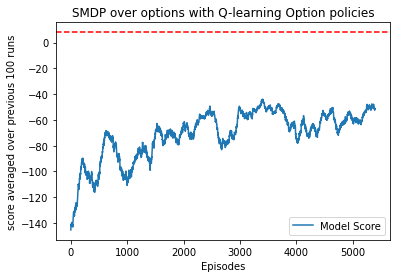

In [154]:
import matplotlib.pyplot as plt
window = 100
avg_rews_smdp = [np.average(rewards_smdp[i:i+window])
                 for i in range(len(rewards_smdp)-window)]
plt.plot(avg_rews_smdp, label='Model Score')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP over options with Q-learning Option policies')
plt.legend()
plt.axhline(y=8, color='red', linestyle='--')

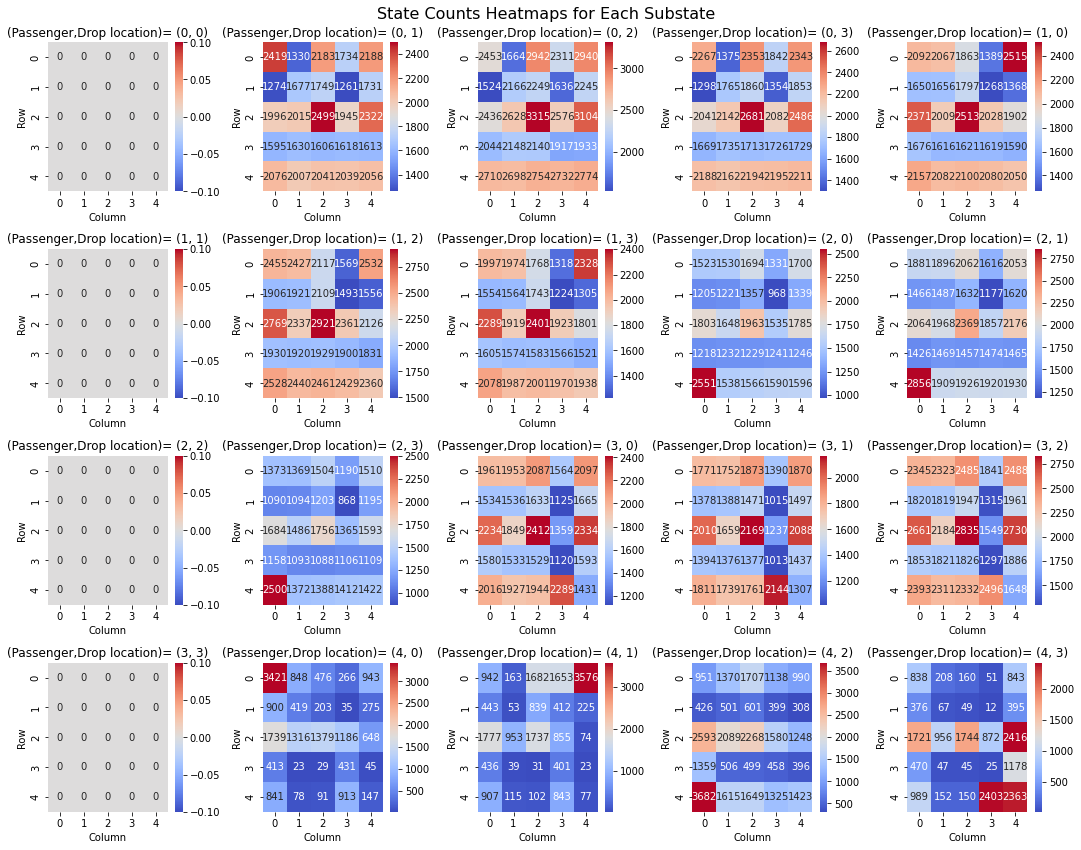

In [151]:
state_array = np.array(state_counts, dtype="int")
num_substates = 20
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for substate in range(num_substates):
    substate_counts_1d = state_array[:, substate]
    substate_counts_2d = substate_counts_1d.reshape((5, 5))

    ax = axes[substate // 5, substate % 5]

    sns.heatmap(substate_counts_2d, annot=True,
                cmap='coolwarm', fmt='d', ax=ax)

    ax.set_title(
        f'(Passenger,Drop location)= {substate//nDrops,substate%nDrops}')

    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

fig.suptitle('State Counts Heatmaps for Each Substate', fontsize=16)
plt.tight_layout()
plt.show()

In [152]:
env = gym.make("Taxi-v3", render_mode="human")
state, _ = env.reset()
done = False
in_taxi = False
q_values_SMDP = Q_smdp
total_reward = 0
x, y, pas, drop = env.decode(state)
print(f"Running for substate {nDrops*pas+drop}")
while not done:
    x, y, pas, drop = env.decode(state)
    subState = nDrops*pas+drop
    action = np.argmax(q_values_SMDP[5*x+y, subState])
    optdone = False
    move = 0
    prev = state
    while (optdone == False) and not done:
        x, y, pas, drop = env.decode(state)
        optdone = False
        if not optdone and not done:
            optact = action
            for j in range(2):
                taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                    state)
                next_state, reward, done, truncated, _ = env.step(optact)
                steps += 1
                taxi_row_new, taxi_col_new, passenger_location_id, drop_location_id = env.decode(
                    next_state)
                total_reward += reward
                reward_bar = gamma*reward_bar + reward
                reward_surr = reward
                locations = {0: [0, 0], 1: [0, 4], 2: [4, 0],
                             3: [4, 3], 4: [taxi_row, taxi_col]}
                loc = locations[passenger_location_id]
                taxi_row, taxi_col, passenger_location_id, drop_location_id = env.decode(
                    next_state)
                if loc[0] == taxi_row and loc[1] == taxi_col and drop_location_id != passenger_location_id and not in_taxi:
                    optact = 4
                    in_taxi = True
                    optdone = True
                    next_state, reward, done, truncated, _ = env.step(optact)
                    total_reward += reward
                    break
                if goal[drop_location_id][0] == taxi_row and goal[drop_location_id][1] == taxi_col and passenger_location_id == 4:
                    optact = 5
                    optdone = True
                    number_drops += 1
                    next_state, reward, done, truncated, _ = env.step(optact)
                    total_reward += reward
                    break
                state = next_state
            optdone = True
print(f"Total Reward for this substate = {total_reward}")

Running for substate 3


KeyboardInterrupt: 

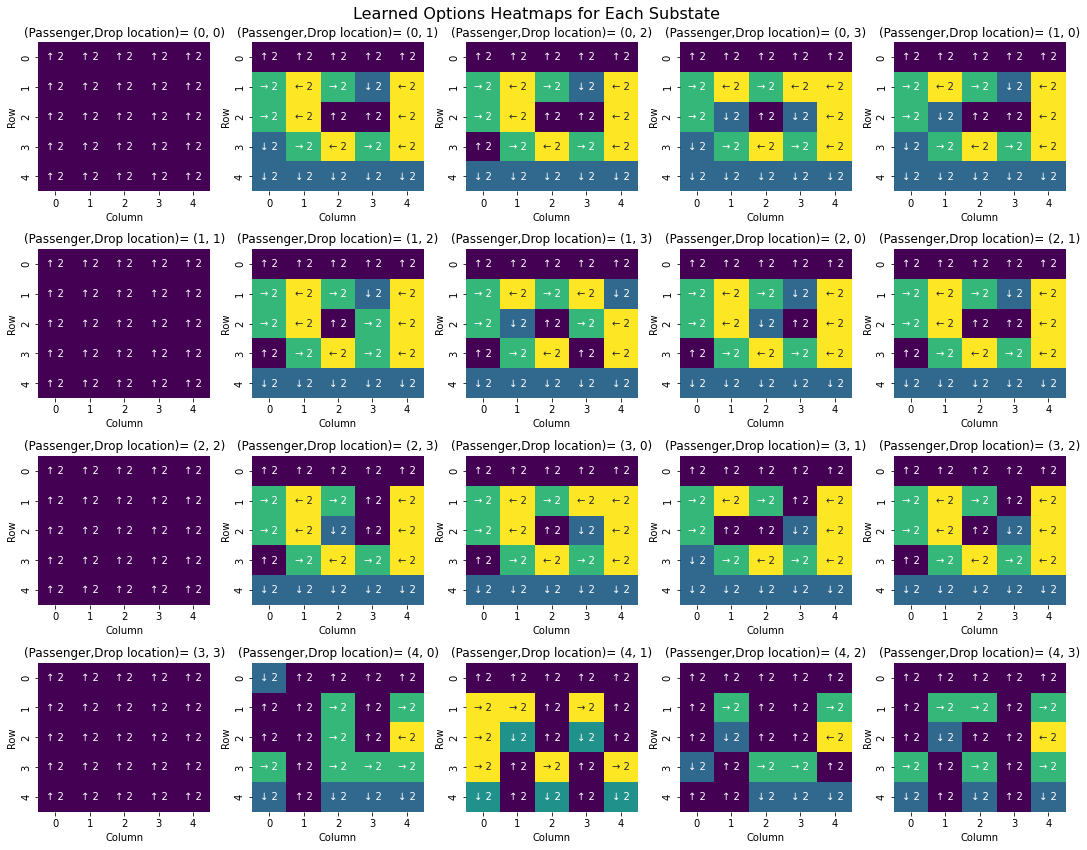

In [143]:
import seaborn as sns
substates = 20
option_names = {
    0: "↑ 2",
    1: "↓ 2",
    2: "→ 2",
    3: "← 2"
}
num_substates = 20

fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for substate in range(num_substates):
    learned_options = np.argmax(Q_smdp[:, substate], axis=1)
    learned_options_names = np.vectorize(option_names.get)(learned_options)
    learned_options_2d = learned_options.reshape((5, 5))
    annot_text = learned_options_names.reshape((5, 5))
    ax = axes[substate // 5, substate % 5]
    sns.heatmap(learned_options_2d, annot=annot_text,
                cmap='viridis', fmt='', ax=ax, cbar=False)
    ax.set_title(
        f'(Passenger,Drop location)= {substate//nDrops,substate%nDrops}')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

fig.suptitle('Learned Options Heatmaps for Each Substate', fontsize=16)
plt.tight_layout()
plt.show()